# Loading

In [11]:
#Here, all the necessary imports are made.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import csv

In [12]:
#Here, the data is loaded, adjust path as needed.
DATA_DIR = '/Users/larsheijnen/Thesis/Final/MDS-UPDRS_Part_III_21Mar2025.csv'
data = pd.read_csv(DATA_DIR)

In [13]:
# Print the number of features (columns) in the dataset
print("Number of features:", len(data.columns))

# Display the column names
print("\nFeature names:")
for col in data.columns:
    print(f"- {col}")

unique_patients = data['PATNO'].nunique()
print(f"Number of unique patients: {unique_patients}")

# Display some basic statistics about patients
print("\nPatient visit statistics:")
patient_visits = data.groupby('PATNO').size()
print(f"Average visits per patient: {patient_visits.mean():.2f}")
print(f"Min visits per patient: {patient_visits.min()}")
print(f"Max visits per patient: {patient_visits.max()}")

Number of features: 63

Feature names:
- REC_ID
- PATNO
- EVENT_ID
- PAG_NAME
- INFODT
- PDTRTMNT
- PDSTATE
- HRPOSTMED
- HRDBSON
- HRDBSOFF
- PDMEDYN
- DBSYN
- ONOFFORDER
- OFFEXAM
- OFFNORSN
- DBSOFFTM
- ONEXAM
- ONNORSN
- HIFUYN
- DBSONTM
- PDMEDDT
- PDMEDTM
- EXAMDT
- EXAMTM
- NP3SPCH
- NP3FACXP
- NP3RIGN
- NP3RIGRU
- NP3RIGLU
- NP3RIGRL
- NP3RIGLL
- NP3FTAPR
- NP3FTAPL
- NP3HMOVR
- NP3HMOVL
- NP3PRSPR
- NP3PRSPL
- NP3TTAPR
- NP3TTAPL
- NP3LGAGR
- NP3LGAGL
- NP3RISNG
- NP3GAIT
- NP3FRZGT
- NP3PSTBL
- NP3POSTR
- NP3BRADY
- NP3PTRMR
- NP3PTRML
- NP3KTRMR
- NP3KTRML
- NP3RTARU
- NP3RTALU
- NP3RTARL
- NP3RTALL
- NP3RTALJ
- NP3RTCON
- NP3TOT
- DYSKPRES
- DYSKIRAT
- NHY
- ORIG_ENTRY
- LAST_UPDATE
Number of unique patients: 4313

Patient visit statistics:
Average visits per patient: 7.50
Min visits per patient: 1
Max visits per patient: 40


In [14]:
# Convert date columns to datetime where possible
for col in ['INFODT', 'EXAMDT', 'ORIG_ENTRY', 'LAST_UPDATE']:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

# Convert specific date columns
data['EXAMDT'] = pd.to_datetime(data['EXAMDT'], errors='coerce')
data['INFODT'] = pd.to_datetime(data['INFODT'], errors='coerce')

# Fallback: fill missing EXAMDT with INFODT
data['EXAMDT'] = data['EXAMDT'].fillna(data['INFODT'])

print("Earliest visit:", data['EXAMDT'].min())
print("Latest visit:", data['EXAMDT'].max())
print("Median interval between visits (days):", 
      data.sort_values(['PATNO', 'EXAMDT']).groupby('PATNO')['EXAMDT'].diff().median())


#Check outliers or wrong values
np3_cols = [col for col in data.columns if col.startswith('NP3') and col != 'NP3TOT']

# Find out-of-range values
out_of_range = (data[np3_cols] < 0) | (data[np3_cols] > 4)
if out_of_range.any().any():
    print("Warning: Out-of-range NP3 scores detected!")
    display(data.loc[out_of_range.any(axis=1), ['PATNO', 'EXAMDT'] + np3_cols])
else:
    print("All NP3 scores within expected range (0–4). Ignored values in the NP3TOT column.")

Earliest visit: 2010-07-01 00:00:00
Latest visit: 2025-03-01 00:00:00
Median interval between visits (days): 181 days 00:00:00


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_76269/1986860071.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_76269/1986860071.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_76269/1986860071.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce')


,PATNO,EXAMDT,NP3SPCH,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,...,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON
62,3002,2022-03-01,2.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,3003,2022-04-01,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,3009,2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,3010,2022-11-01,3.0,2.0,101.0,101.0,101.0,101.0,101.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,3010,2023-12-01,3.0,2.0,101.0,101.0,101.0,101.0,101.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32212,349772,2025-02-01,0.0,0.0,101.0,101.0,101.0,101.0,101.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32246,359738,2024-09-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32247,359738,2025-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32259,366799,2025-01-01,0.0,0.0,101.0,101.0,101.0,101.0,101.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Replace 101 values with NaN in NP3 columns, 101 values are placed in the data to indicate missing values.
np3_cols = [col for col in data.columns if col.startswith('NP3') and col != 'NP3TOT']
data[np3_cols] = data[np3_cols].replace(101, np.nan)
# Also replace 101 in NHY column with NaN
data['NHY'] = data['NHY'].replace(101, np.nan)


# Find out-of-range values
# Find and remove out-of-range values
out_of_range = (data[np3_cols] < 0) | (data[np3_cols] > 4)
if out_of_range.any().any():
    print("Warning: Out-of-range NP3 scores detected!")
    print(f"Found {out_of_range.sum().sum()} out-of-range values")
    # Replace out-of-range values with NaN
    data.loc[out_of_range] = np.nan
    print("Out-of-range values have been replaced with NaN")
else:
    print("All NP3 scores within expected range (0–4). Ignored NP3TOT.")

print(f"Remaining rows after filtering NP3TOT: {len(data)}")

# Drop rows where NP3TOT is NaN
data = data.dropna(subset=['NP3TOT'])
print(f"Remaining rows after dropping NaN NP3TOT: {len(data)}")


All NP3 scores within expected range (0–4). Ignored NP3TOT.
Remaining rows after filtering NP3TOT: 32346
Remaining rows after dropping NaN NP3TOT: 26109


In [16]:
# Count unique patients
unique_patients = data['PATNO'].nunique()
print(f"Number of unique patients: {unique_patients}")

# Display some basic statistics about patients
print("\nPatient visit statistics:")
patient_visits = data.groupby('PATNO').size()
print(f"Average visits per patient: {patient_visits.mean():.2f}")
print(f"Min visits per patient: {patient_visits.min()}")
print(f"Max visits per patient: {patient_visits.max()}")



Number of unique patients: 4298

Patient visit statistics:
Average visits per patient: 6.07
Min visits per patient: 1
Max visits per patient: 35


# Exploratory Data Analysis / # Data Analysis

Visualize and quantify missingness across key variables using heatmaps and summary statistics.

Summarize the dataset structure, check column meanings, and display initial rows to understand the data.

In [17]:
# Sort by PATNO and visit date (prefer EXAMDT, fallback to INFODT if EXAMDT is missing)
#INFODT is the date of the information, EXAMDT is the date of the visit. They are most of the time the same.
if 'EXAMDT' in data.columns:
    data = data.sort_values(['PATNO', 'EXAMDT'])
elif 'INFODT' in data.columns:
    data = data.sort_values(['PATNO', 'INFODT'])

# Remove post-baseline visits with EXAMDT on or before baseline for each patient. This unlikely ever happens.
if 'EXAMDT' in data.columns and 'PATNO' in data.columns:
    baseline_dates = data.groupby('PATNO')['EXAMDT'].transform('min')
    # Keep only visits after baseline or the baseline itself
    mask = (data['EXAMDT'] > baseline_dates) | (data['EXAMDT'] == baseline_dates)
    n_before = data.shape[0]
    data = data[mask]
    n_after = data.shape[0]
    print(f"Removed {n_before - n_after} visits with EXAMDT on or before baseline (except baseline itself).")

assert pd.api.types.is_datetime64_any_dtype(data['EXAMDT'])

# Create a visit number per patient
data['VISIT_NUM'] = data.groupby('PATNO').cumcount()

# Show a summary of the data.
print(data[['PATNO', 'EXAMDT', 'EVENT_ID', 'PDSTATE', 'NP3TOT', 'VISIT_NUM']].head(10))




Removed 0 visits with EXAMDT on or before baseline (except baseline itself).
    PATNO     EXAMDT EVENT_ID PDSTATE  NP3TOT  VISIT_NUM
0    3000 2011-02-01       BL     NaN     4.0          0
1    3000 2012-03-01      V04     NaN     1.0          1
2    3000 2013-02-01      V06     NaN     4.0          2
3    3000 2014-03-01      V08     NaN     2.0          3
4    3000 2015-03-01      V10     NaN    19.0          4
5    3000 2016-04-01      V12     NaN     3.0          5
6    3000 2018-02-01      V14     NaN    10.0          6
7    3000 2019-03-01      V15     NaN     5.0          7
8    3000 2021-05-01      V17     NaN     3.0          8
10   3001 2011-02-01       SC     NaN    18.0          0


In [18]:
# Check for paired ON/OFF visits (same PATNO, EVENT_ID, different PDSTATE).
paired = data.groupby(['PATNO', 'EVENT_ID'])['PDSTATE'].nunique()
paired_onoff = paired[paired > 1]
print("Number of ON/OFF paired visits:", paired_onoff.count())

Number of ON/OFF paired visits: 3573


<function matplotlib.pyplot.show(close=None, block=None)>

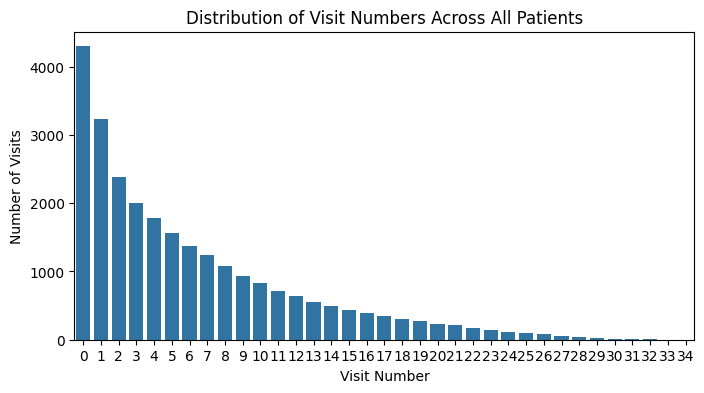

In [19]:
# Plot the distribution of visit numbers (VISIT_NUM), where each row is a visit (so multiple per PATNO)
plt.figure(figsize=(8, 4))
sns.countplot(x='VISIT_NUM', data=data)
plt.title('Distribution of Visit Numbers Across All Patients')
plt.xlabel('Visit Number')
plt.ylabel('Number of Visits')
plt.show

Descriptive statistics:
              NP3TOT           NHY       NP3SPCH      NP3FACXP       NP3RIGN  \
count  26109.000000  26096.000000  26109.000000  26109.000000  26109.000000   
mean      16.869126      1.210799      0.465395      0.849899      0.582673   
std       14.683221      0.992777      0.668630      0.865489      0.830761   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.000000      0.000000      0.000000      0.000000      0.000000   
50%       15.000000      2.000000      0.000000      1.000000      0.000000   
75%       26.000000      2.000000      1.000000      1.000000      1.000000   
max      100.000000      5.000000      4.000000      4.000000      4.000000   

            NP3GAIT      NP3BRADY  
count  26109.000000  26109.000000  
mean       0.614386      0.893179  
std        0.714158      0.927159  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        1.000000      1.000000  
75%        

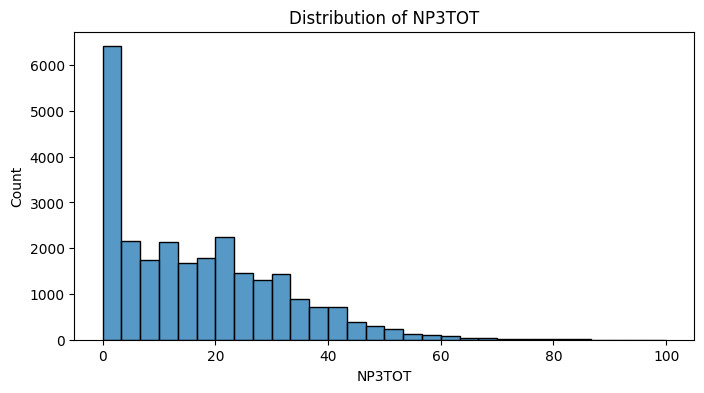

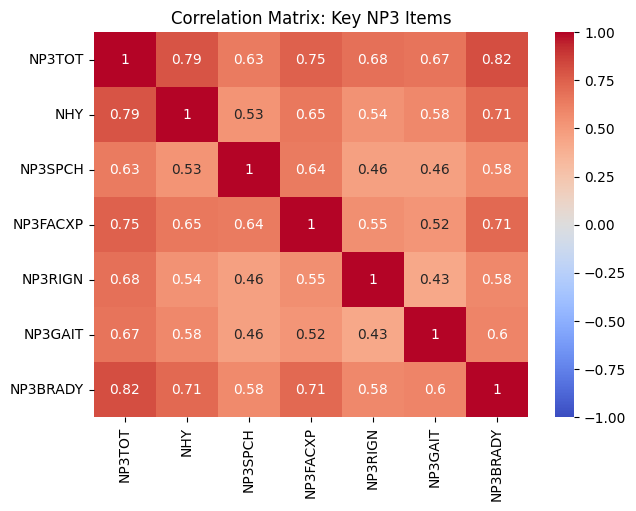

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Descriptive statistics for NP3TOT, NHY, and key NP3 items
key_items = ['NP3TOT', 'NHY', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3GAIT', 'NP3BRADY']
desc = data[key_items].describe()
print("Descriptive statistics:\n", desc)

# Plot: Distribution of NP3TOT
plt.figure(figsize=(8, 4))
sns.histplot(data['NP3TOT'].dropna(), bins=30, kde=False)
plt.title('Distribution of NP3TOT')
plt.xlabel('NP3TOT')
plt.ylabel('Count')
plt.show()

# Plot: Correlation heatmap for key NP3 items
corr_matrix = data[key_items].corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix: Key NP3 Items')
plt.show()

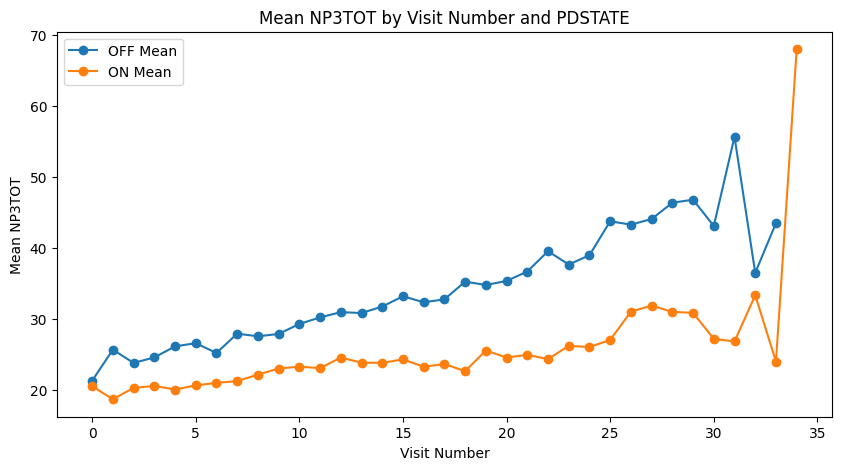

In [21]:
plt.figure(figsize=(10, 5))
data['PDSTATE'] = data['PDSTATE'].astype('category')
for state in data['PDSTATE'].cat.categories:
    state_data = data[data['PDSTATE'] == state]
    mean_trend = state_data.groupby('VISIT_NUM')['NP3TOT'].mean()
    plt.plot(mean_trend.index, mean_trend.values, marker='o', label=f'{state} Mean')
plt.xlabel('Visit Number')
plt.ylabel('Mean NP3TOT')
plt.title('Mean NP3TOT by Visit Number and PDSTATE')
plt.legend()
plt.show()

# 1. Clear Separation Between ON and OFF States
# -------------------------------------------
# • OFF state (blue): Higher NP3TOT scores consistently across all visits
# • ON state (orange): Lower NP3TOT scores throughout, indicating symptom improvement with medication

# 2. Temporal Trends
# ----------------
# • Both groups show a gradual increase in NP3TOT over time, reflecting disease progression
# • Rate of increase is steeper in the OFF state, showing more pronounced worsening when unmedicated

# 3. Late-Stage Volatility (Visits ~30–34)
# --------------------------------------
# • Both curves become more erratic near the end (especially Visit 34)
# • Likely causes:
#   - Small sample sizes (dropout attrition over time)
#   - Increased heterogeneity in late disease stages
#   - Data artifacts (Visit 34 shows dramatic jump in ON state)

# Key Insights
# -------------
# • Medication (ON state) consistently reduces symptom burden, but doesn't stop progression
# • Gap between ON and OFF widens slightly over time, suggesting increasing reliance on medication
# • End-point spikes should be examined closely for possible outliers or data sparsity

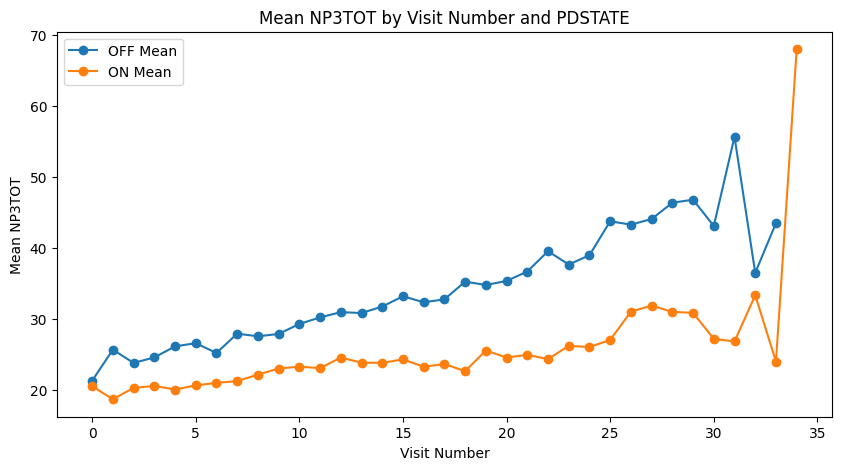

In [22]:
plt.figure(figsize=(10, 5))
data['PDSTATE'] = data['PDSTATE'].astype('category')
for state in data['PDSTATE'].cat.categories:
    state_data = data[data['PDSTATE'] == state]
    mean_trend = state_data.groupby('VISIT_NUM')['NP3TOT'].mean()
    plt.plot(mean_trend.index, mean_trend.values, marker='o', label=f'{state} Mean')
plt.xlabel('Visit Number')
plt.ylabel('Mean NP3TOT')
plt.title('Mean NP3TOT by Visit Number and PDSTATE')
plt.legend()
plt.show()

# 1. Clear Separation Between ON and OFF States
# -------------------------------------------
# • OFF state (blue): Higher NP3TOT scores consistently across all visits
# • ON state (orange): Lower NP3TOT scores throughout, indicating symptom improvement with medication

# 2. Temporal Trends
# ----------------
# • Both groups show a gradual increase in NP3TOT over time, reflecting disease progression
# • Rate of increase is steeper in the OFF state, showing more pronounced worsening when unmedicated

# 3. Late-Stage Volatility (Visits ~30–34)
# --------------------------------------
# • Both curves become more erratic near the end (especially Visit 34)
# • Likely causes:
#   - Small sample sizes (dropout attrition over time)
#   - Increased heterogeneity in late disease stages
#   - Data artifacts (Visit 34 shows dramatic jump in ON state)

# Key Insights
# -------------
# • Medication (ON state) consistently reduces symptom burden, but doesn't stop progression
# • Gap between ON and OFF widens slightly over time, suggesting increasing reliance on medication
# • End-point spikes should be examined closely for possible outliers or data sparsity

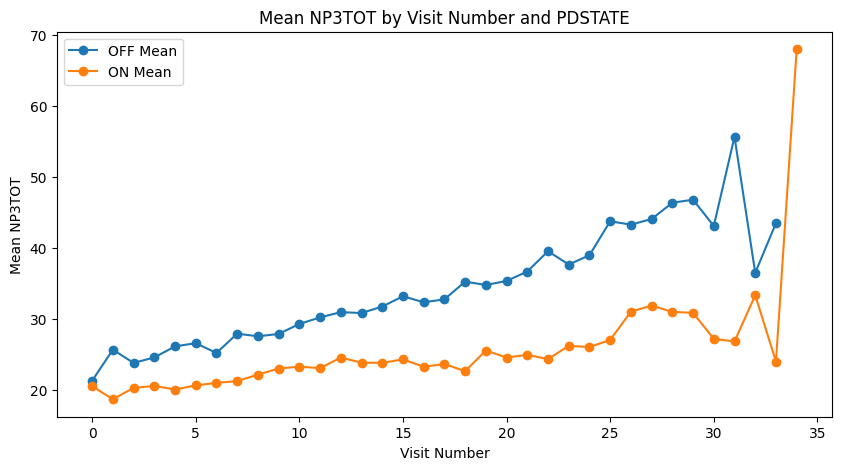

In [23]:
plt.figure(figsize=(10, 5))
data['PDSTATE'] = data['PDSTATE'].astype('category')
for state in data['PDSTATE'].cat.categories:
    state_data = data[data['PDSTATE'] == state]
    mean_trend = state_data.groupby('VISIT_NUM')['NP3TOT'].mean()
    plt.plot(mean_trend.index, mean_trend.values, marker='o', label=f'{state} Mean')
plt.xlabel('Visit Number')
plt.ylabel('Mean NP3TOT')
plt.title('Mean NP3TOT by Visit Number and PDSTATE')
plt.legend()
plt.show()

# 1. Clear Separation Between ON and OFF States
# -------------------------------------------
# • OFF state (blue): Higher NP3TOT scores consistently across all visits
# • ON state (orange): Lower NP3TOT scores throughout, indicating symptom improvement with medication

# 2. Temporal Trends
# ----------------
# • Both groups show a gradual increase in NP3TOT over time, reflecting disease progression
# • Rate of increase is steeper in the OFF state, showing more pronounced worsening when unmedicated

# 3. Late-Stage Volatility (Visits ~30–34)
# --------------------------------------
# • Both curves become more erratic near the end (especially Visit 34)
# • Likely causes:
#   - Small sample sizes (dropout attrition over time)
#   - Increased heterogeneity in late disease stages
#   - Data artifacts (Visit 34 shows dramatic jump in ON state)

# Key Insights
# -------------
# • Medication (ON state) consistently reduces symptom burden, but doesn't stop progression
# • Gap between ON and OFF widens slightly over time, suggesting increasing reliance on medication
# • End-point spikes should be examined closely for possible outliers or data sparsity

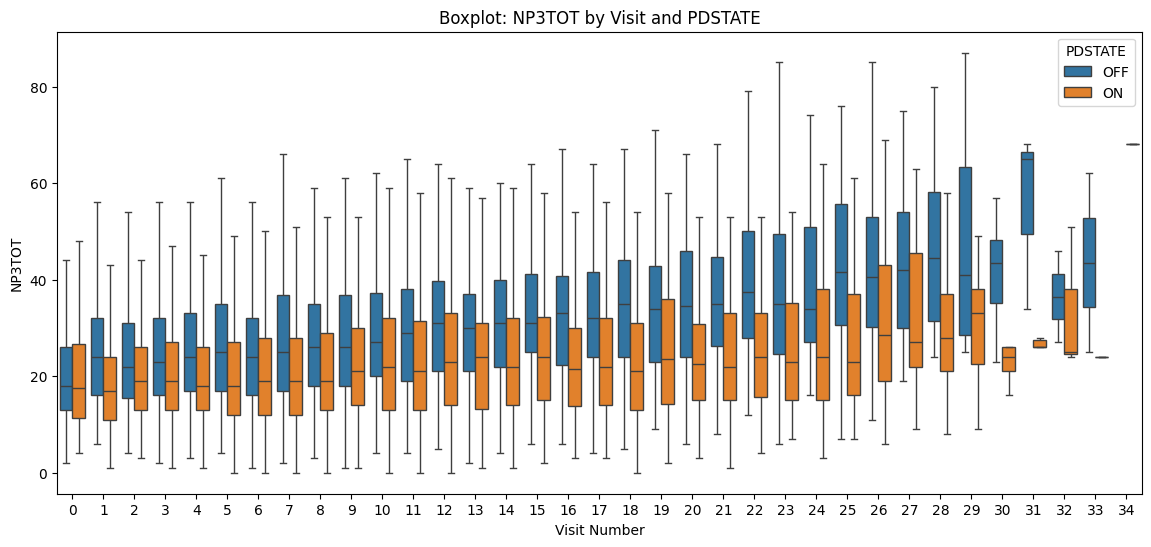

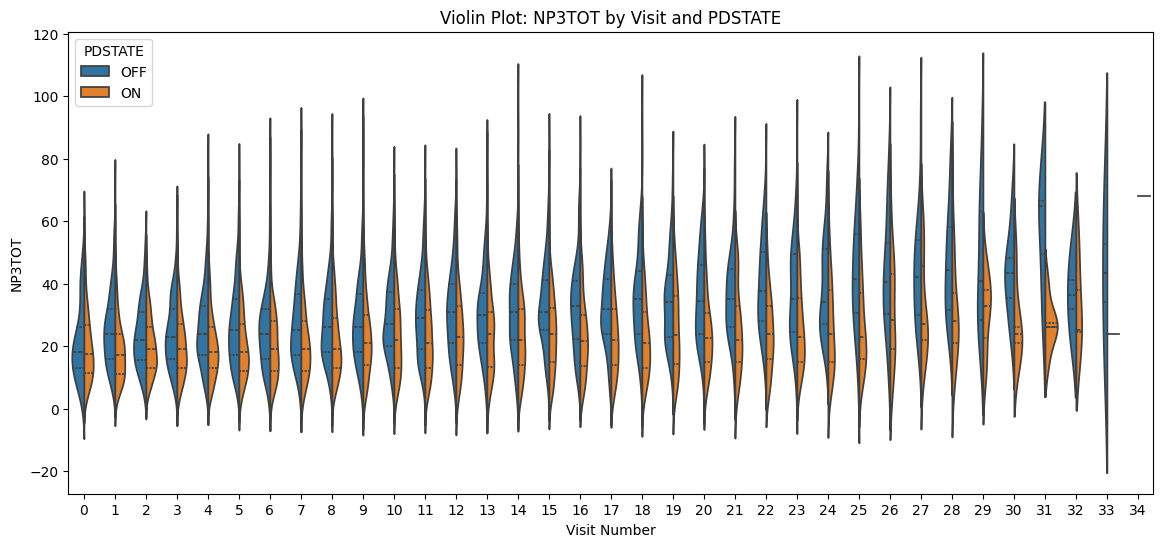

In [24]:
# 3. Boxplots/violin plots: NP3TOT by visit and PDSTATE
plt.figure(figsize=(14, 6))
sns.boxplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, showfliers=False)
plt.title('Boxplot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, split=True, inner='quartile')
plt.title('Violin Plot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

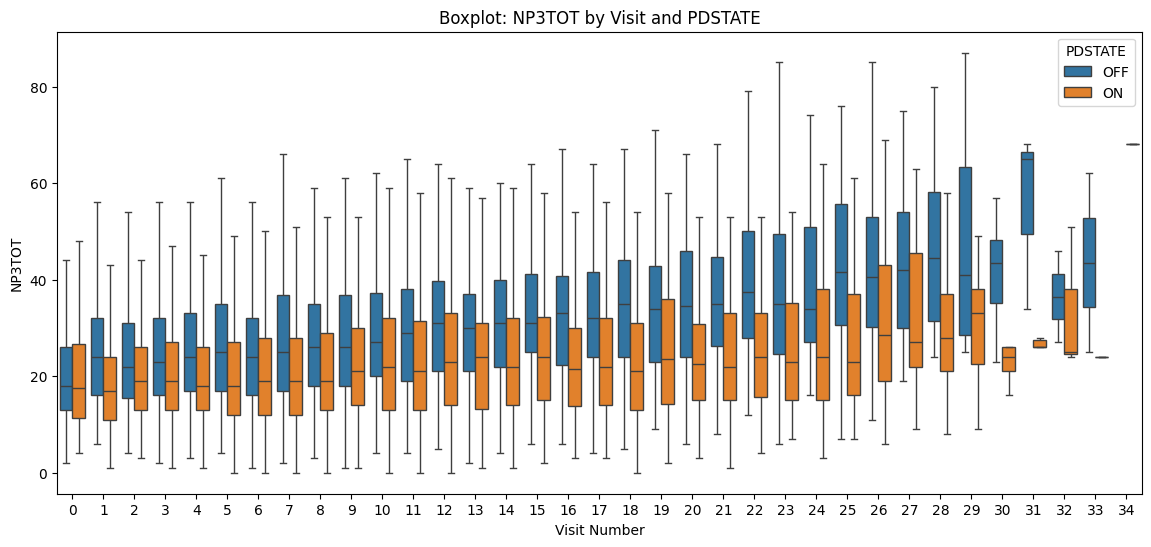

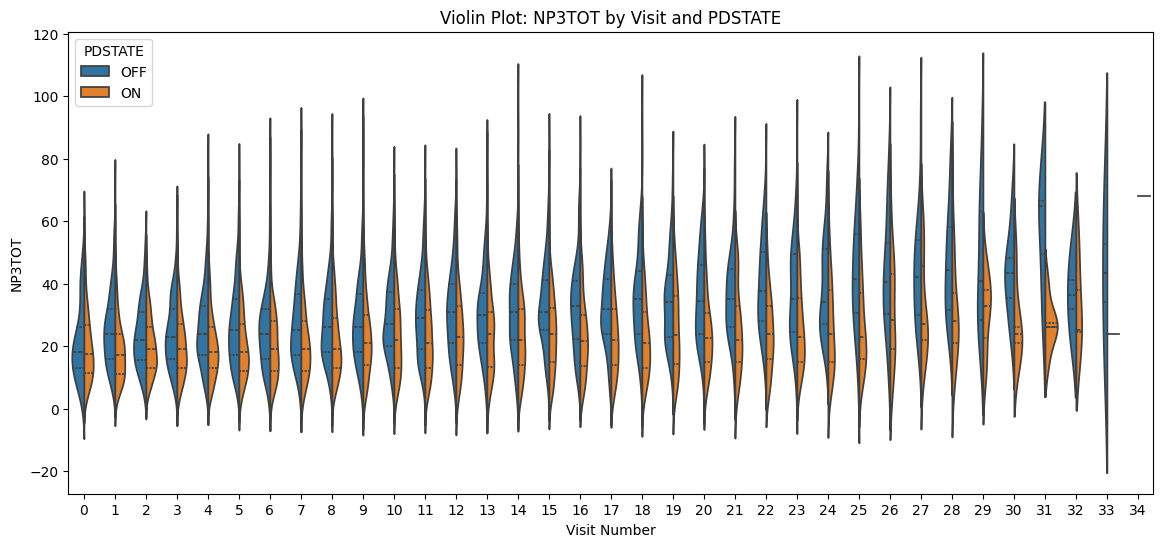

In [25]:
# 3. Boxplots/violin plots: NP3TOT by visit and PDSTATE
plt.figure(figsize=(14, 6))
sns.boxplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, showfliers=False)
plt.title('Boxplot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, split=True, inner='quartile')
plt.title('Violin Plot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

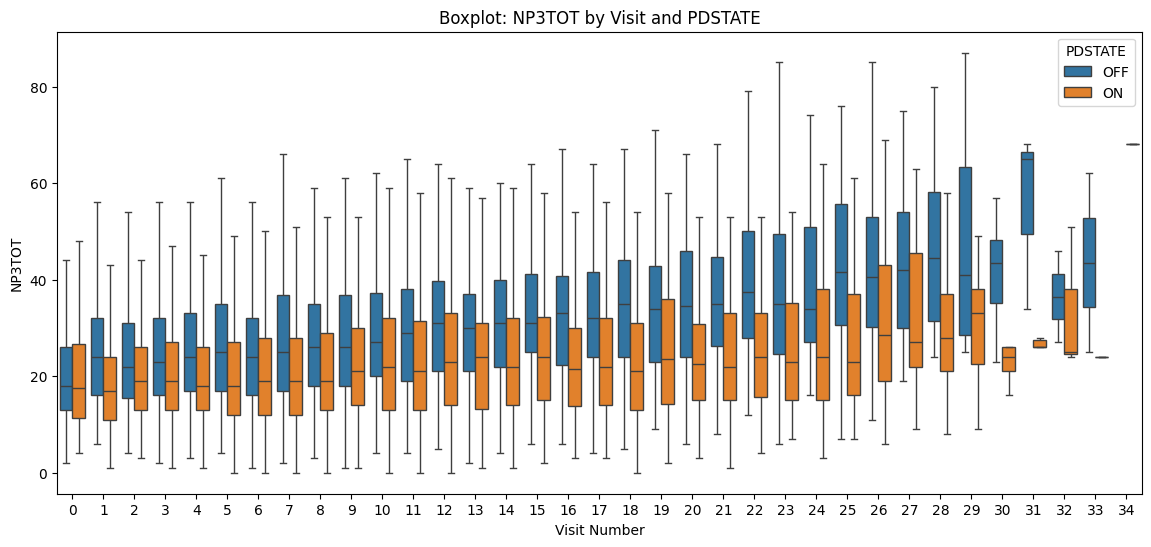

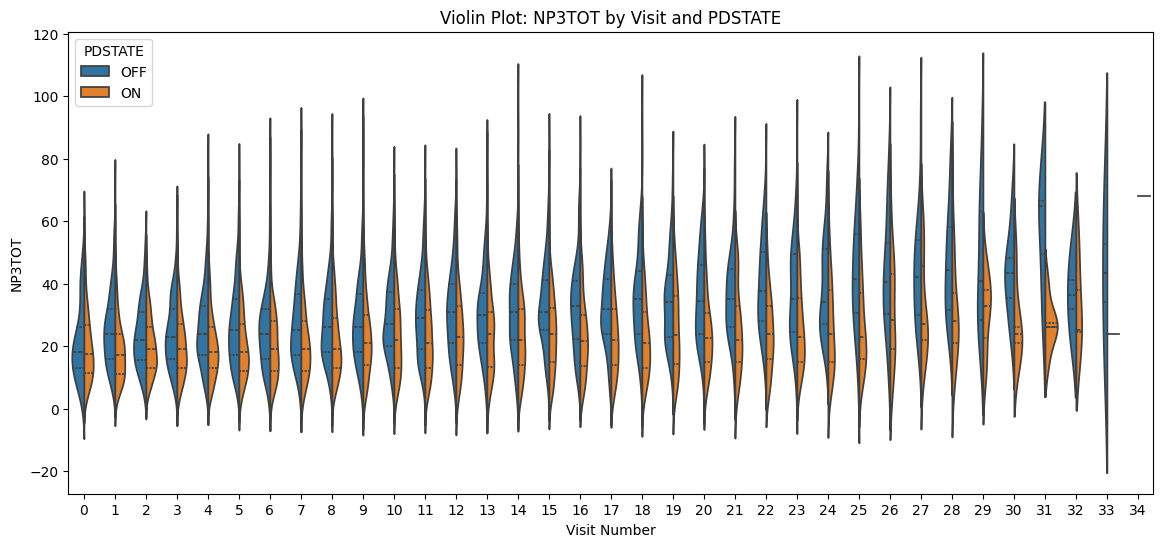

In [26]:
# 3. Boxplots/violin plots: NP3TOT by visit and PDSTATE
plt.figure(figsize=(14, 6))
sns.boxplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, showfliers=False)
plt.title('Boxplot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, split=True, inner='quartile')
plt.title('Violin Plot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

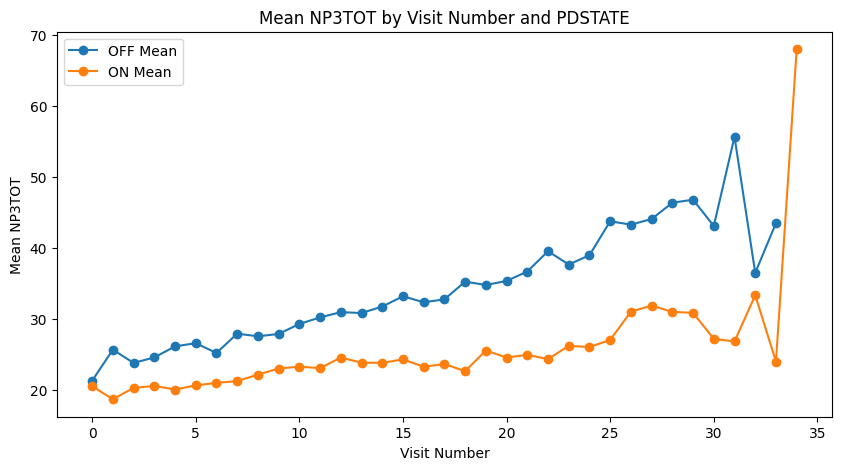

In [27]:
plt.figure(figsize=(10, 5))
data['PDSTATE'] = data['PDSTATE'].astype('category')
for state in data['PDSTATE'].cat.categories:
    state_data = data[data['PDSTATE'] == state]
    mean_trend = state_data.groupby('VISIT_NUM')['NP3TOT'].mean()
    plt.plot(mean_trend.index, mean_trend.values, marker='o', label=f'{state} Mean')
plt.xlabel('Visit Number')
plt.ylabel('Mean NP3TOT')
plt.title('Mean NP3TOT by Visit Number and PDSTATE')
plt.legend()
plt.show()

# 1. Clear Separation Between ON and OFF States
# -------------------------------------------
# • OFF state (blue): Higher NP3TOT scores consistently across all visits
# • ON state (orange): Lower NP3TOT scores throughout, indicating symptom improvement with medication

# 2. Temporal Trends
# ----------------
# • Both groups show a gradual increase in NP3TOT over time, reflecting disease progression
# • Rate of increase is steeper in the OFF state, showing more pronounced worsening when unmedicated

# 3. Late-Stage Volatility (Visits ~30–34)
# --------------------------------------
# • Both curves become more erratic near the end (especially Visit 34)
# • Likely causes:
#   - Small sample sizes (dropout attrition over time)
#   - Increased heterogeneity in late disease stages
#   - Data artifacts (Visit 34 shows dramatic jump in ON state)

# Key Insights
# -------------
# • Medication (ON state) consistently reduces symptom burden, but doesn't stop progression
# • Gap between ON and OFF widens slightly over time, suggesting increasing reliance on medication
# • End-point spikes should be examined closely for possible outliers or data sparsity

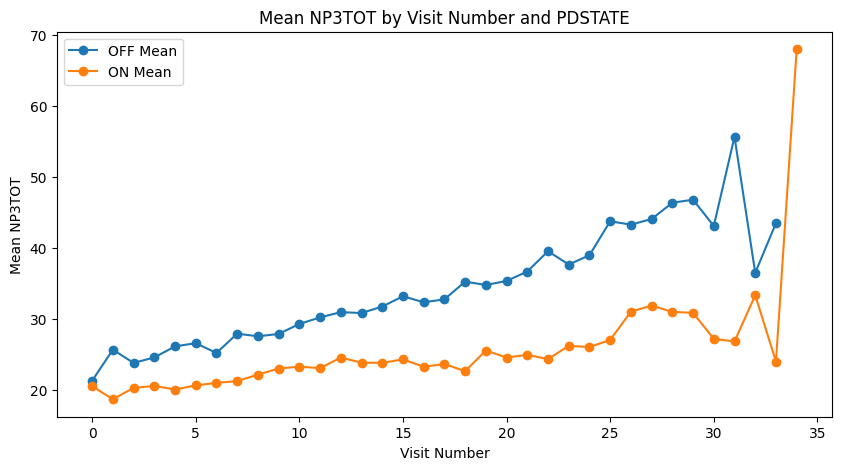

In [28]:
plt.figure(figsize=(10, 5))
data['PDSTATE'] = data['PDSTATE'].astype('category')
for state in data['PDSTATE'].cat.categories:
    state_data = data[data['PDSTATE'] == state]
    mean_trend = state_data.groupby('VISIT_NUM')['NP3TOT'].mean()
    plt.plot(mean_trend.index, mean_trend.values, marker='o', label=f'{state} Mean')
plt.xlabel('Visit Number')
plt.ylabel('Mean NP3TOT')
plt.title('Mean NP3TOT by Visit Number and PDSTATE')
plt.legend()
plt.show()

# 1. Clear Separation Between ON and OFF States
# -------------------------------------------
# • OFF state (blue): Higher NP3TOT scores consistently across all visits
# • ON state (orange): Lower NP3TOT scores throughout, indicating symptom improvement with medication

# 2. Temporal Trends
# ----------------
# • Both groups show a gradual increase in NP3TOT over time, reflecting disease progression
# • Rate of increase is steeper in the OFF state, showing more pronounced worsening when unmedicated

# 3. Late-Stage Volatility (Visits ~30–34)
# --------------------------------------
# • Both curves become more erratic near the end (especially Visit 34)
# • Likely causes:
#   - Small sample sizes (dropout attrition over time)
#   - Increased heterogeneity in late disease stages
#   - Data artifacts (Visit 34 shows dramatic jump in ON state)

# Key Insights
# -------------
# • Medication (ON state) consistently reduces symptom burden, but doesn't stop progression
# • Gap between ON and OFF widens slightly over time, suggesting increasing reliance on medication
# • End-point spikes should be examined closely for possible outliers or data sparsity

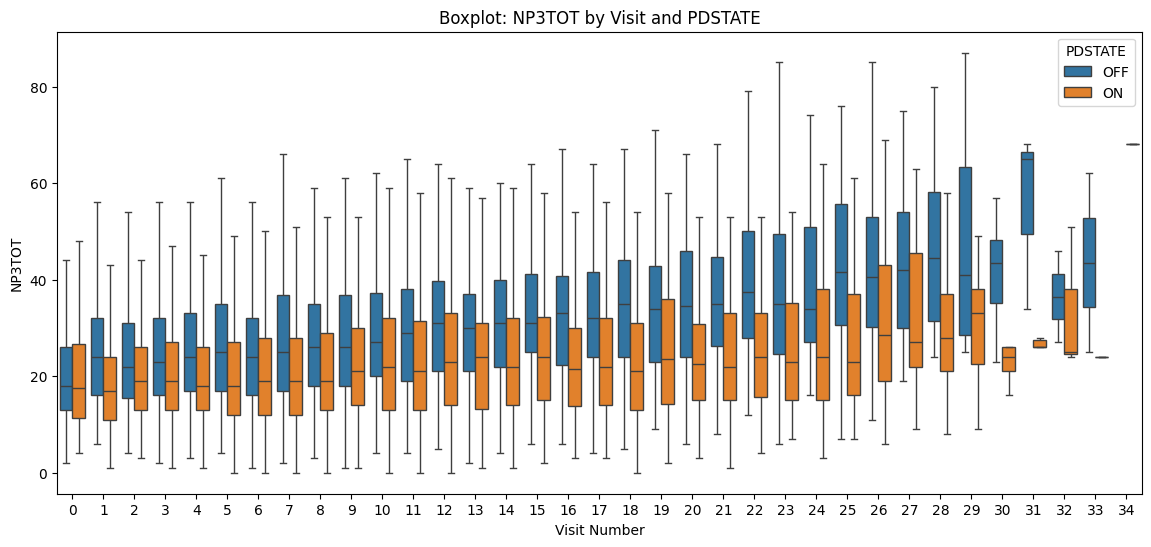

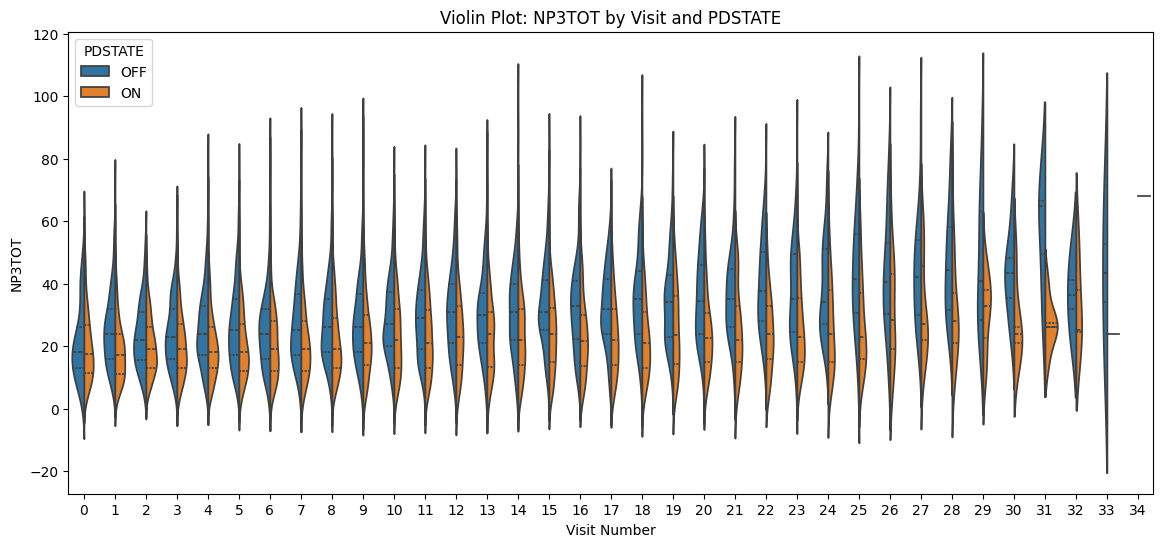

In [29]:
# 3. Boxplots/violin plots: NP3TOT by visit and PDSTATE
plt.figure(figsize=(14, 6))
sns.boxplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, showfliers=False)
plt.title('Boxplot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, split=True, inner='quartile')
plt.title('Violin Plot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

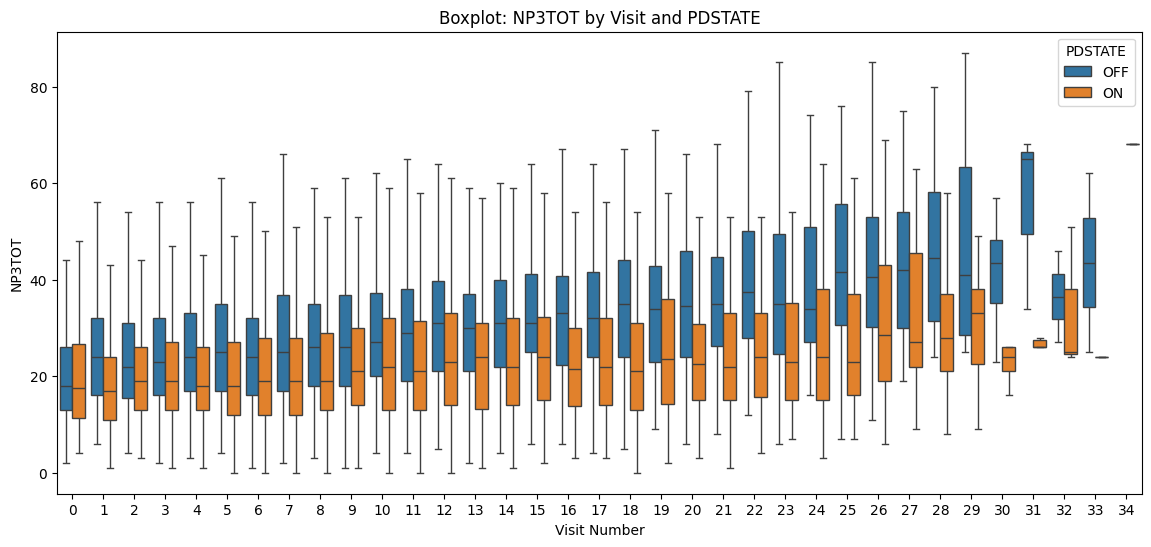

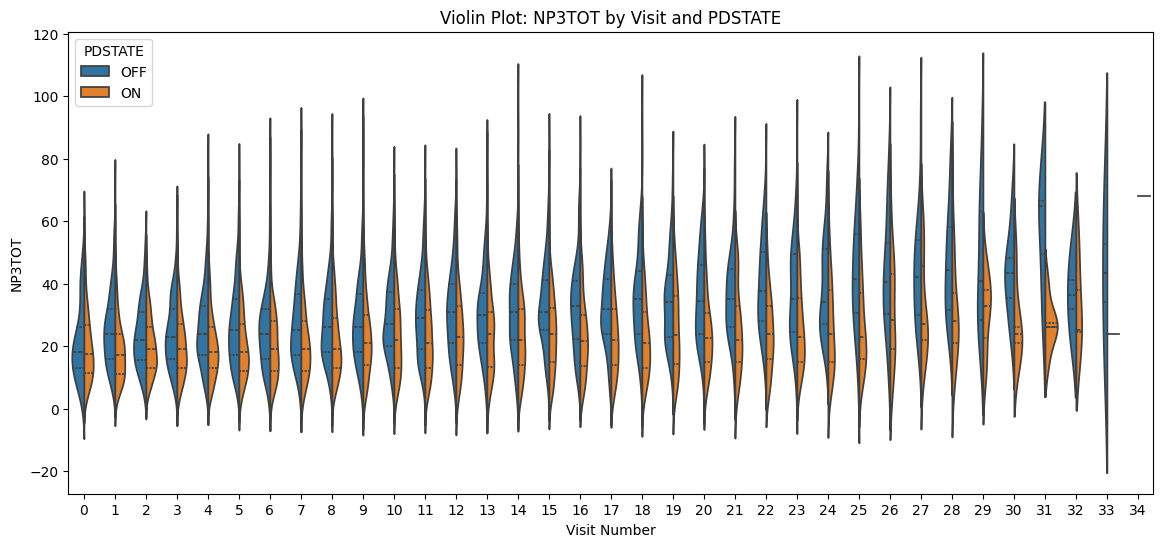

In [30]:
# 3. Boxplots/violin plots: NP3TOT by visit and PDSTATE
plt.figure(figsize=(14, 6))
sns.boxplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, showfliers=False)
plt.title('Boxplot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, split=True, inner='quartile')
plt.title('Violin Plot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

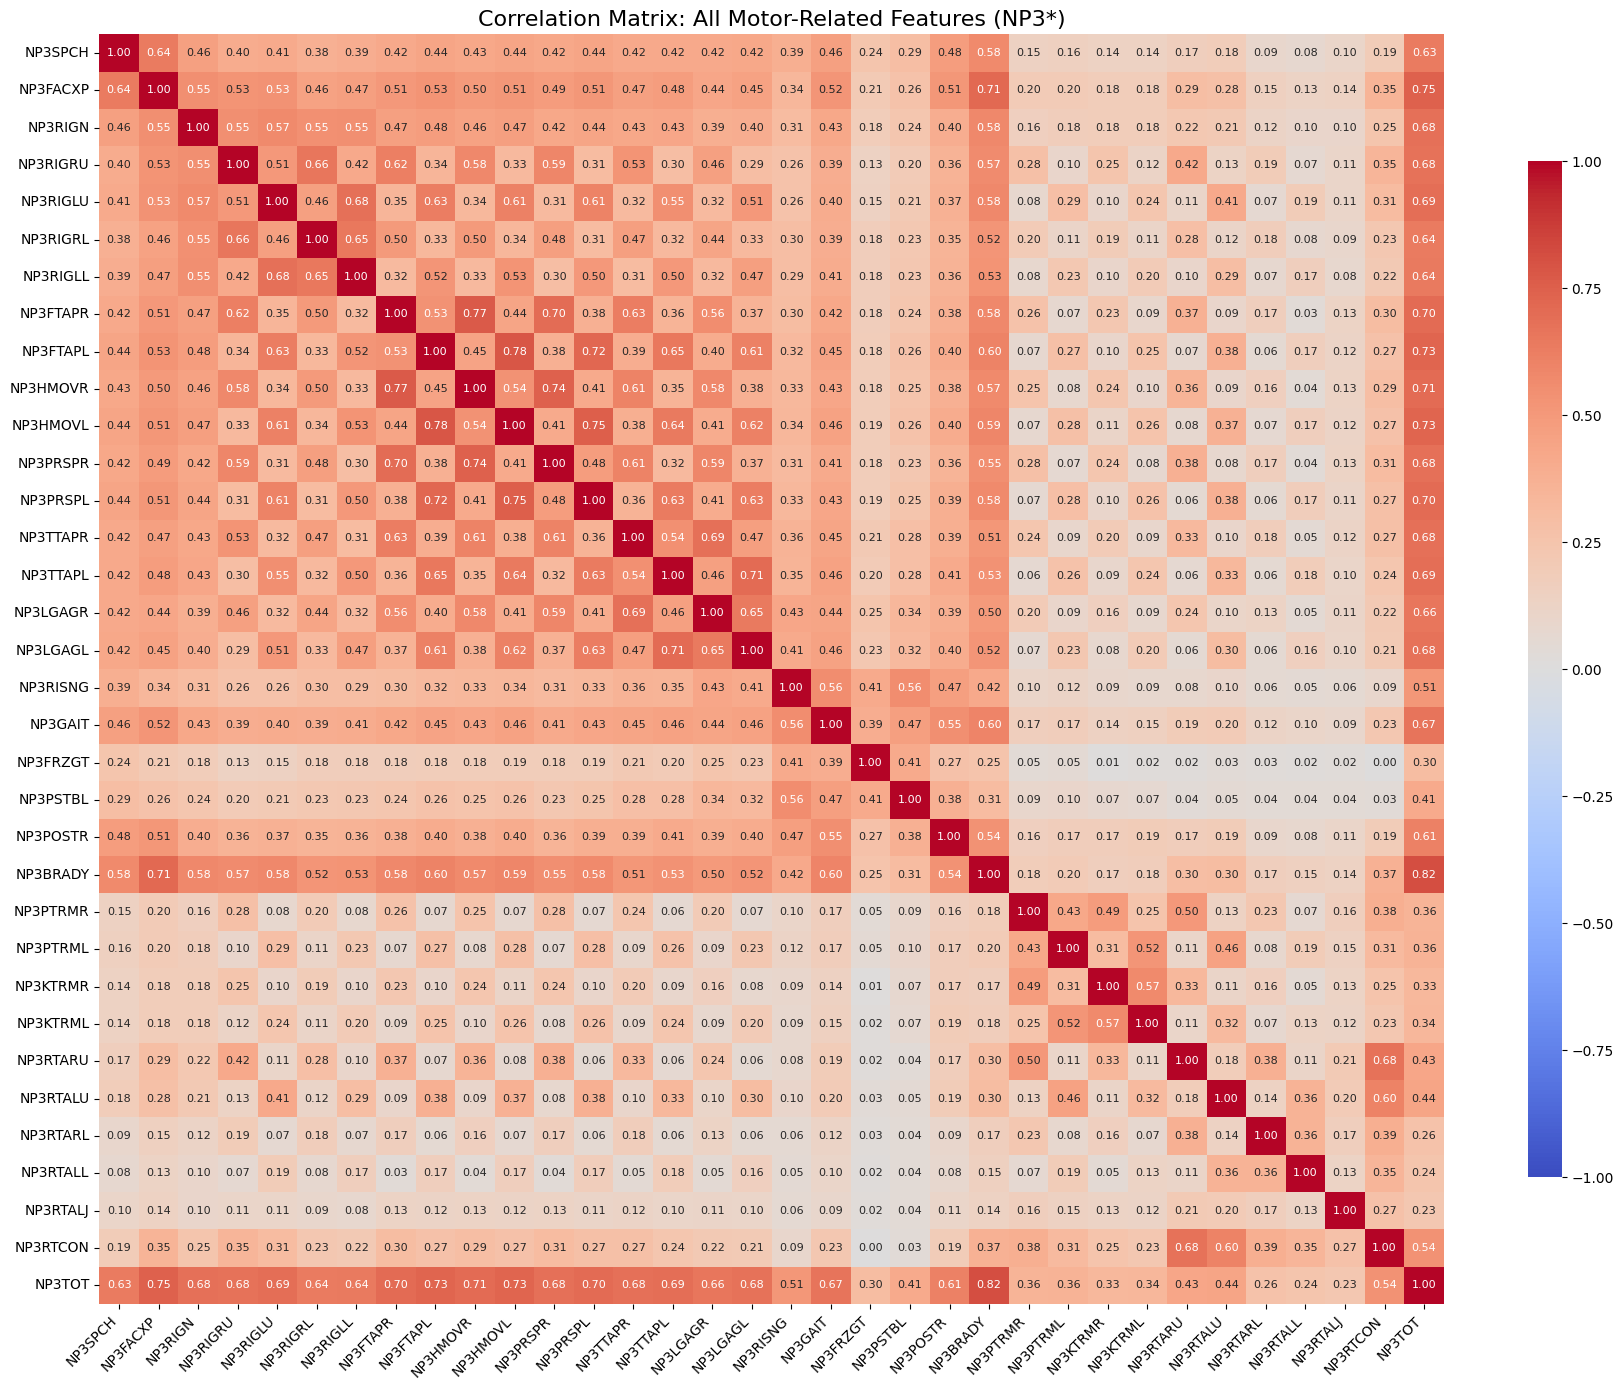

In [31]:
# Plot the correlation matrix for all motor-related features as a heatmap,
# but ignore any features related to NP3TOT log or sqrt transformations.

# Define all motor-related features (based on MDS-UPDRS Part III, NP3* columns)
# Exclude NP3TOT_log and NP3TOT_sqrt if present
motor_features = [
    col for col in data.columns
    if col.startswith('NP3') and col not in ['NP3TOT_log', 'NP3TOT_sqrt']
]

# Compute correlation matrix for these features
motor_corr = data[motor_features].corr()

# Plot the correlation heatmap with improved formatting
plt.figure(figsize=(18, 14))  # Make the figure larger for better readability
sns.heatmap(
    motor_corr, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    vmin=-1, vmax=1, 
    annot_kws={"size":8},   # Smaller font for annotations
    cbar_kws={"shrink": 0.8, "aspect": 30}
)
plt.title('Correlation Matrix: All Motor-Related Features (NP3*)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [32]:
# Check visit intervals (in days) for a sample patient, this is important for later on.
sample_patno = data['PATNO'].dropna().unique()[0]
sample = data[data['PATNO'] == sample_patno].sort_values('EXAMDT')
if sample['EXAMDT'].notna().sum() > 1:
    sample['VISIT_DIFF_DAYS'] = sample['EXAMDT'].diff().dt.days
    print(sample[['PATNO', 'EXAMDT', 'VISIT_DIFF_DAYS']])

   PATNO     EXAMDT  VISIT_DIFF_DAYS
0   3000 2011-02-01              NaN
1   3000 2012-03-01            394.0
2   3000 2013-02-01            337.0
3   3000 2014-03-01            393.0
4   3000 2015-03-01            365.0
5   3000 2016-04-01            397.0
6   3000 2018-02-01            671.0
7   3000 2019-03-01            393.0
8   3000 2021-05-01            792.0


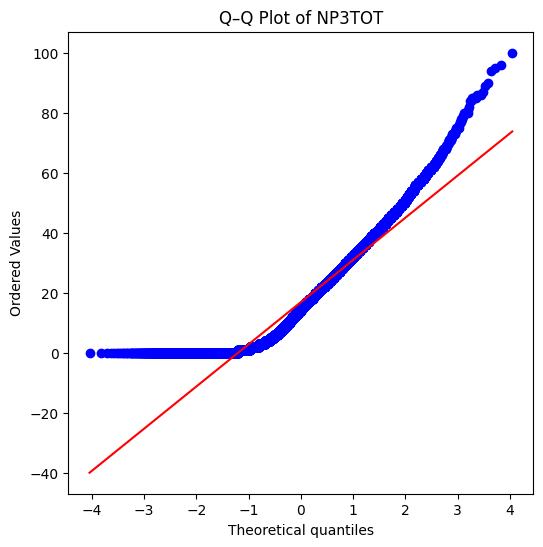

Shapiro–Wilk test for NP3TOT: W=0.919, p=6.71e-78
NP3TOT is NOT normally distributed (reject H0 at α=0.05).


/Users/larsheijnen/Thesis/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26109.
  res = hypotest_fun_out(*samples, **kwds)


In [33]:
from scipy.stats import shapiro
import scipy.stats as stats
import matplotlib.pyplot as plt

# Q–Q plot for NP3TOT
# The Q–Q plot is used to check if the data is normally distributed.
plt.figure(figsize=(6, 6))
stats.probplot(data['NP3TOT'].dropna(), dist="norm", plot=plt)
plt.title('Q–Q Plot of NP3TOT')
plt.show()

# Shapiro–Wilk test
stat, p = shapiro(data['NP3TOT'].dropna())
print(f"Shapiro–Wilk test for NP3TOT: W={stat:.3f}, p={p:.3g}")
if p < 0.05:
    print("NP3TOT is NOT normally distributed (reject H0 at α=0.05).")
else:
    print("NP3TOT is consistent with normality (fail to reject H0 at α=0.05).")


#The distribution of "NP3TOT" is not normal. It appears to be positively skewed, with a likely many low values.
# It is important to note this, especially when performing time-series modelling, since many models assume normality.
# Rejecting the null hypothesis, the data is not normally distributed.


NP3TOT: Shapiro-Wilk p-value = 0.00000


/Users/larsheijnen/Thesis/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26109.
  res = hypotest_fun_out(*samples, **kwds)


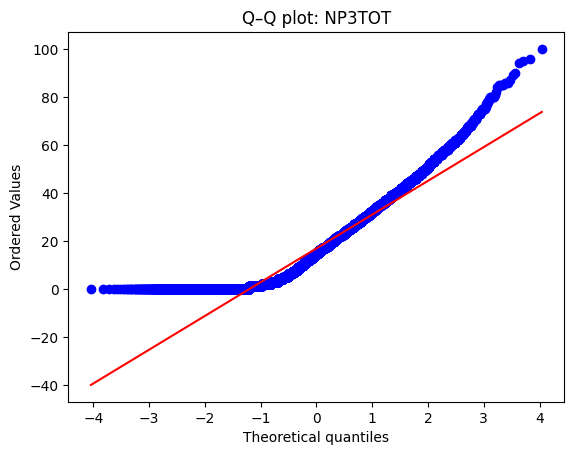

NP3TOT_log: Shapiro-Wilk p-value = 0.00000


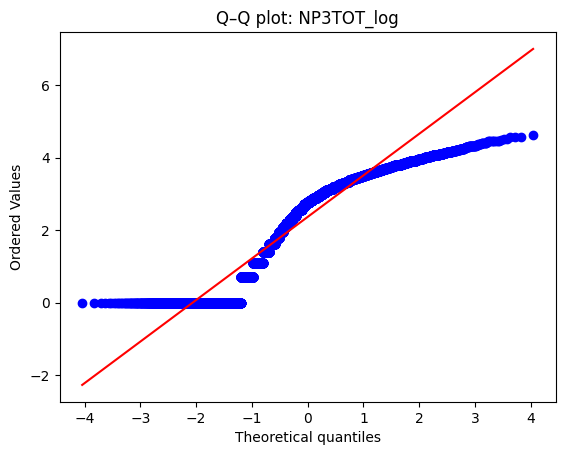

NP3TOT_sqrt: Shapiro-Wilk p-value = 0.00000


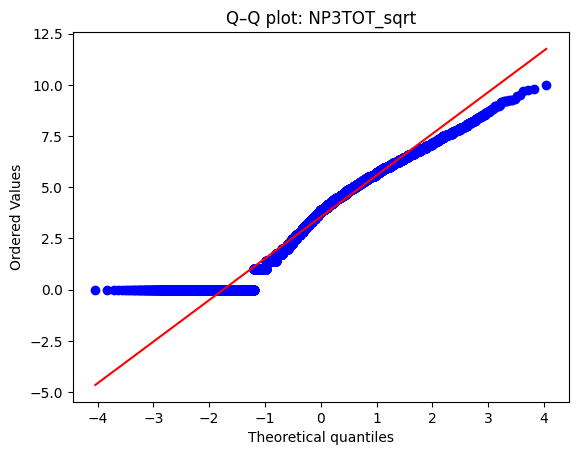

In [34]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Transformation: Shift to avoid log(0)
data['NP3TOT_log'] = np.log1p(data['NP3TOT'])  # log(1 + x)
data['NP3TOT_sqrt'] = np.sqrt(data['NP3TOT'])

# Check normality again
for col in ['NP3TOT', 'NP3TOT_log', 'NP3TOT_sqrt']:
    stat, p = stats.shapiro(data[col].dropna())
    print(f"{col}: Shapiro-Wilk p-value = {p:.5f}")

    stats.probplot(data[col].dropna(), dist="norm", plot=plt)
    plt.title(f"Q–Q plot: {col}")
    plt.show()


# Log Transformed (NP3TOT_log):
# Q-Q Plot: Some improvement, especially in tail behavior, but still clear deviation.
# Shapiro-Wilk p-value: 0.00000 → Still not normal.
# Observation: The stair-step effect suggests many repeated small values (possibly zeros).

# Square Root Transformed (NP3TOT_sqrt):
# Q-Q Plot: Slightly better fit in mid-range values, but tails still deviate.
# Shapiro-Wilk p-value: 0.00000 → Still not normal.

# To conclude:
# Neither log nor square root transformation fully normalize the distribution.
# The data likely contains a large number of zeros or near-zero values (zero-inflated), and is intrinsically non-normal.

#Modeling Perspective:
# Use models that do not assume normality, like:
# Generalized Linear Models (GLMs) with Poisson or Negative Binomial link (if count-like).

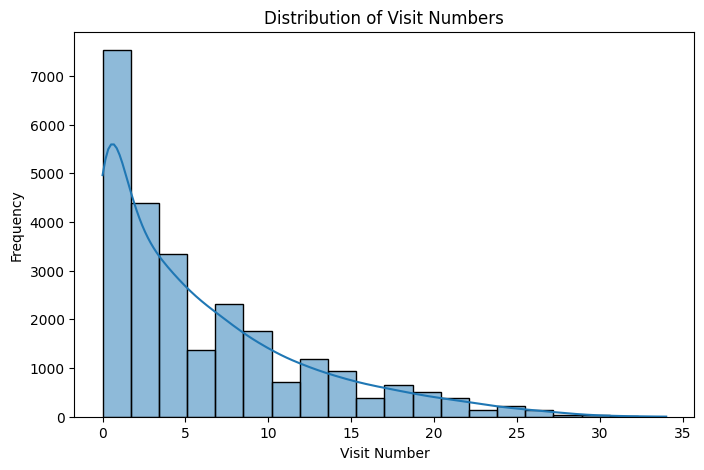

In [35]:
plt.figure(figsize=(8, 5))
sns.histplot(data['VISIT_NUM'], bins=20, kde=True)
plt.title('Distribution of Visit Numbers')
plt.xlabel('Visit Number')
plt.ylabel('Frequency')
plt.show()

In [36]:
missing_patients = {}
for col in key_items:
    n_missing = data.groupby('PATNO')[col].apply(lambda x: x.isna().any()).sum()
    pct_missing = 100 * n_missing / data['PATNO'].nunique()
    missing_patients[col] = pct_missing

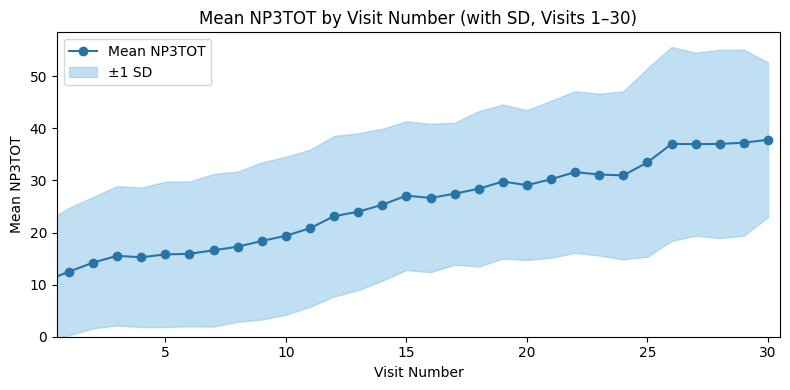

In [37]:
# Calculate mean and standard deviation of NP3TOT by visit number, up to visit 30
mean_by_visit = data.groupby('VISIT_NUM')['NP3TOT'].mean()
std_by_visit = data.groupby('VISIT_NUM')['NP3TOT'].std()

visit_mask = mean_by_visit.index <= 30
mean_by_visit_30 = mean_by_visit[visit_mask]
std_by_visit_30 = std_by_visit[visit_mask]

plt.figure(figsize=(8, 4))
plt.plot(mean_by_visit_30.index, mean_by_visit_30.values, marker='o', color='#2874A6', label='Mean NP3TOT')
plt.fill_between(
    mean_by_visit_30.index,
    mean_by_visit_30.values - std_by_visit_30.values,
    mean_by_visit_30.values + std_by_visit_30.values,
    color='#85C1E9', alpha=0.5, label='±1 SD'
)
plt.xlabel('Visit Number')
plt.ylabel('Mean NP3TOT')
plt.title('Mean NP3TOT by Visit Number (with SD, Visits 1–30)')
plt.ylim(bottom=0)
plt.xlim(left=0.5, right=30.5)
plt.legend()
plt.tight_layout()
plt.show()


NP3TOT by PDSTATE:
          count       mean        std  min   25%   50%   75%    max
PDSTATE                                                            
OFF      4405.0  29.808173  14.219594  1.0  19.0  28.0  38.0  100.0
ON       6863.0  22.489145  12.379274  0.0  13.0  21.0  30.0   89.0


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_76269/50865103.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby('PDSTATE')['NP3TOT'].describe())


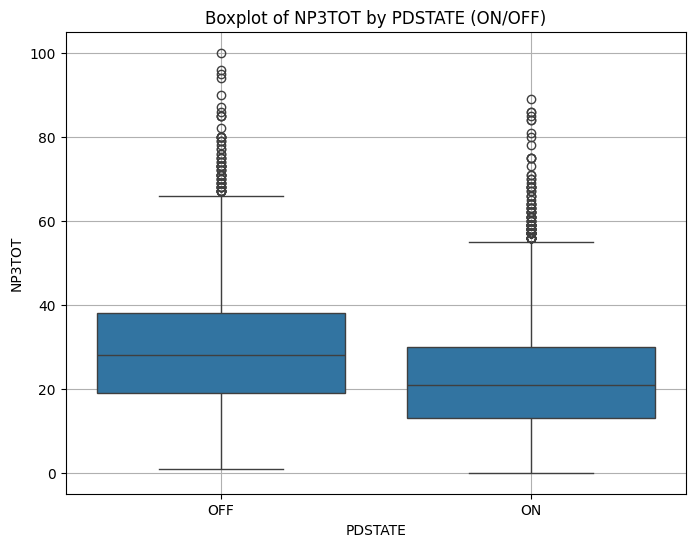

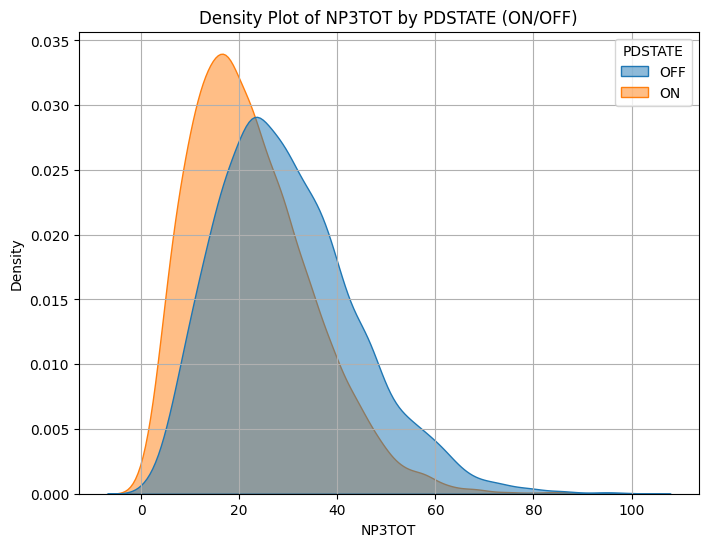

In [38]:
# 2. Stratify by PDSTATE (ON/OFF)
print("\nNP3TOT by PDSTATE:")
print(data.groupby('PDSTATE')['NP3TOT'].describe())

plt.figure(figsize=(8, 6))
sns.boxplot(x='PDSTATE', y='NP3TOT', data=data)
plt.title('Boxplot of NP3TOT by PDSTATE (ON/OFF)')
plt.xlabel('PDSTATE')
plt.ylabel('NP3TOT')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(data=data, x='NP3TOT', hue='PDSTATE', fill=True, common_norm=False, alpha=0.5)
plt.title('Density Plot of NP3TOT by PDSTATE (ON/OFF)')
plt.xlabel('NP3TOT')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# NP3TOT scores are consistently higher in the OFF state, confirming that patients exhibit more severe symptoms when not medicated.
# This validates that PDSTATE is a strong stratifying factor, and any modeling should likely adjust for or include PDSTATE.
# The shift in all percentiles and the higher standard deviation in OFF state supports the clinical reality of fluctuating symptom severity with medication.

In [39]:
# 3. Stratify by EVENT_ID (visit)
print("\nNP3TOT by EVENT_ID (first 5 visits):")
print(data.groupby('EVENT_ID')['NP3TOT'].describe().head())

#Variability is high across events, which aligns with Parkinson’s disease’s fluctuating nature.


NP3TOT by EVENT_ID (first 5 visits):
           count       mean        std  min  25%   50%   75%   max
EVENT_ID                                                          
BL        4229.0  11.222038  11.684420  0.0  2.0   7.0  18.0  71.0
PW          13.0  22.923077  21.765652  0.0  8.0  14.0  38.0  70.0
R01        103.0   6.611650   8.173646  0.0  1.0   4.0   9.0  43.0
R04         33.0   7.090909   8.527029  0.0  2.0   4.0  10.0  36.0
R06         73.0  18.315068  14.102676  0.0  6.0  17.0  28.0  57.0


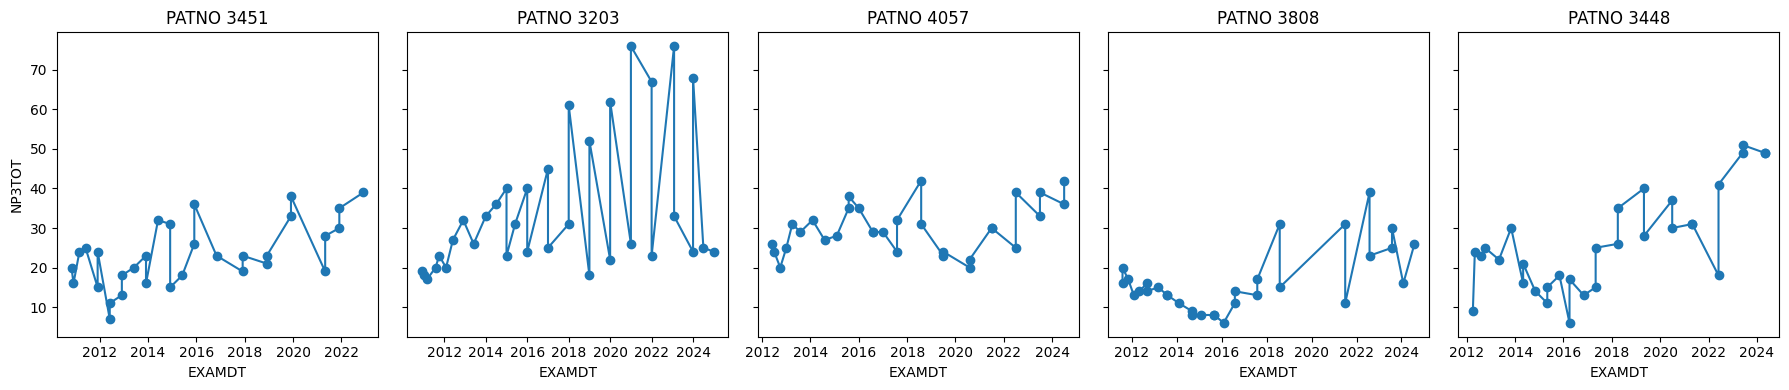

In [40]:
sample_patnos = [3451, 3203, 4057, 3808, 3448]

fig, axes = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
for ax, patno in zip(axes, sample_patnos):
    patient = data[(data['PATNO'] == patno) & data['EXAMDT'].notna() & data['NP3TOT'].notna()]
    patient = patient.sort_values('EXAMDT')
    ax.plot(patient['EXAMDT'], patient['NP3TOT'], marker='o')
    ax.set_title(f'PATNO {patno}')
    ax.set_xlabel('EXAMDT')
axes[0].set_ylabel('NP3TOT')
plt.tight_layout()
plt.show()

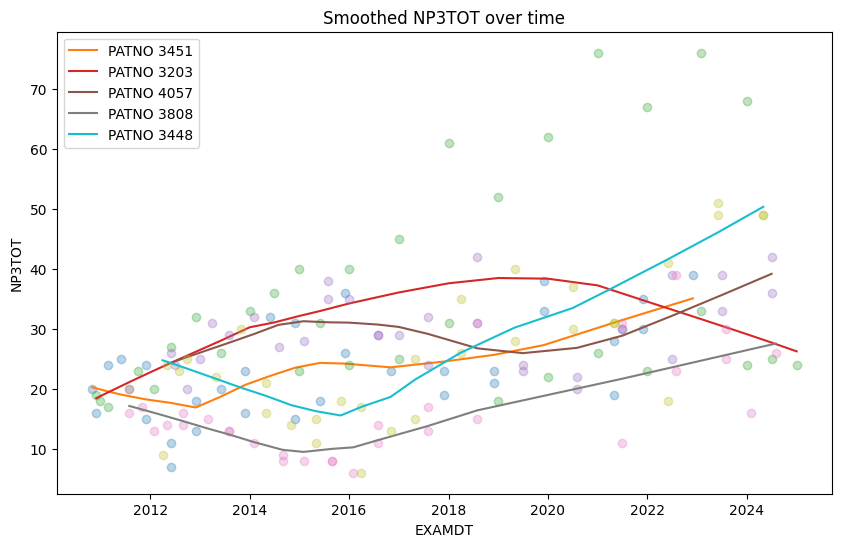

In [41]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
for patno in sample_patnos:
    patient = data[(data['PATNO'] == patno) & data['EXAMDT'].notna() & data['NP3TOT'].notna()]
    patient = patient.sort_values('EXAMDT')
    if len(patient) > 2:
        # Convert EXAMDT to matplotlib date numbers for LOWESS
        x = mdates.date2num(patient['EXAMDT'])
        y = patient['NP3TOT'].values
        smoothed = lowess(y, x, frac=0.5)
        # Plot original points
        plt.plot(patient['EXAMDT'], y, 'o', alpha=0.3)
        # Plot smoothed line, converting x back to datetime
        plt.plot(mdates.num2date(smoothed[:, 0]), smoothed[:, 1], label=f'PATNO {patno}')
plt.xlabel('EXAMDT')
plt.ylabel('NP3TOT')
plt.title('Smoothed NP3TOT over time')
plt.legend()
plt.show()

# Modeling Disease Progression

Fit linear mixed models or other longitudinal models to estimate progression rates and account for within-patient correlation.

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

In [43]:
# 1. Calculate change in NP3TOT from baseline for each patient
data['NP3TOT_BL'] = data.groupby('PATNO')['NP3TOT'].transform('first')
data['NP3TOT_CHANGE'] = data['NP3TOT'] - data['NP3TOT_BL']
print("Change from baseline (first 10 rows):")
print(data[['PATNO', 'EXAMDT', 'NP3TOT', 'NP3TOT_BL', 'NP3TOT_CHANGE']].head(10))

#Allows tracking disease progression relative to baseline, rather than absolute scores.
# Helps in:
    # Longitudinal plotting (e.g., spaghetti plots or smoothed trends).
    # Modeling change as an outcome (e.g., mixed-effects models).
    # Identifying responders vs. non-responders to treatment/intervention.


Change from baseline (first 10 rows):
    PATNO     EXAMDT  NP3TOT  NP3TOT_BL  NP3TOT_CHANGE
0    3000 2011-02-01     4.0        4.0            0.0
1    3000 2012-03-01     1.0        4.0           -3.0
2    3000 2013-02-01     4.0        4.0            0.0
3    3000 2014-03-01     2.0        4.0           -2.0
4    3000 2015-03-01    19.0        4.0           15.0
5    3000 2016-04-01     3.0        4.0           -1.0
6    3000 2018-02-01    10.0        4.0            6.0
7    3000 2019-03-01     5.0        4.0            1.0
8    3000 2021-05-01     3.0        4.0           -1.0
10   3001 2011-02-01    18.0       18.0            0.0


In [44]:
# 3. Treatment effect: ON vs. OFF within-patient (paired analysis)
paired_idx = data.groupby(['PATNO', 'EVENT_ID'])['PDSTATE'].transform('nunique') > 1
paired_data = data[paired_idx]
on_scores = paired_data[paired_data['PDSTATE'] == 'ON'].set_index(['PATNO', 'EVENT_ID'])
off_scores = paired_data[paired_data['PDSTATE'] == 'OFF'].set_index(['PATNO', 'EVENT_ID'])
common_idx = on_scores.index.intersection(off_scores.index)
np3tot_diff = on_scores.loc[common_idx, 'NP3TOT'] - off_scores.loc[common_idx, 'NP3TOT']
print("\nON - OFF NP3TOT difference (summary):")
print(np3tot_diff.describe())


ON - OFF NP3TOT difference (summary):
count    3579.000000
mean       -9.559654
std         8.299959
min       -90.000000
25%       -13.000000
50%        -8.000000
75%        -4.000000
max        18.000000
Name: NP3TOT, dtype: float64


In [45]:
from scipy.stats import ttest_rel, wilcoxon

# Paired t-test
t, p_t = ttest_rel(on_scores['NP3TOT'], off_scores['NP3TOT'])
print(f"Paired t-test ON vs. OFF: t={t:.2f}, p={p_t:.3g}")

# Wilcoxon signed-rank test (non-parametric)
w, p_w = wilcoxon(on_scores['NP3TOT'], off_scores['NP3TOT'])
print(f"Wilcoxon signed-rank test ON vs. OFF: W={w:.2f}, p={p_w:.3g}")

if p_t < 0.05:
    print("Significant difference between ON and OFF (paired t-test).")
if p_w < 0.05:
    print("Significant difference between ON and OFF (Wilcoxon).")

Paired t-test ON vs. OFF: t=-68.91, p=0
Wilcoxon signed-rank test ON vs. OFF: W=66749.50, p=0
Significant difference between ON and OFF (paired t-test).
Significant difference between ON and OFF (Wilcoxon).


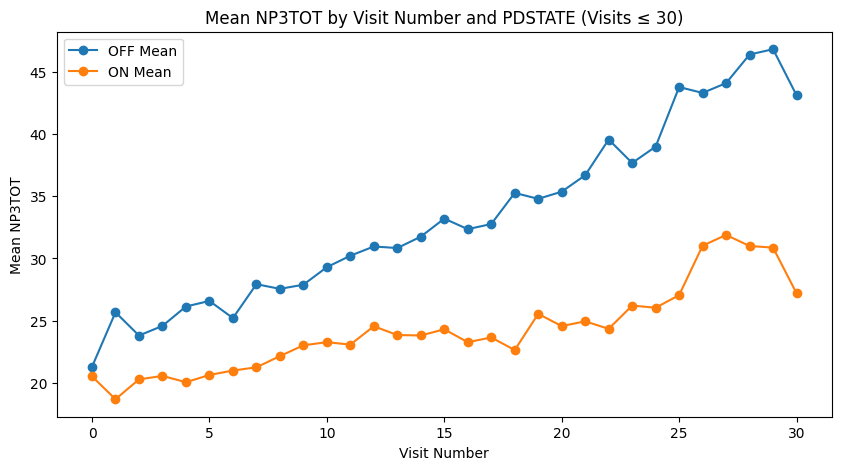

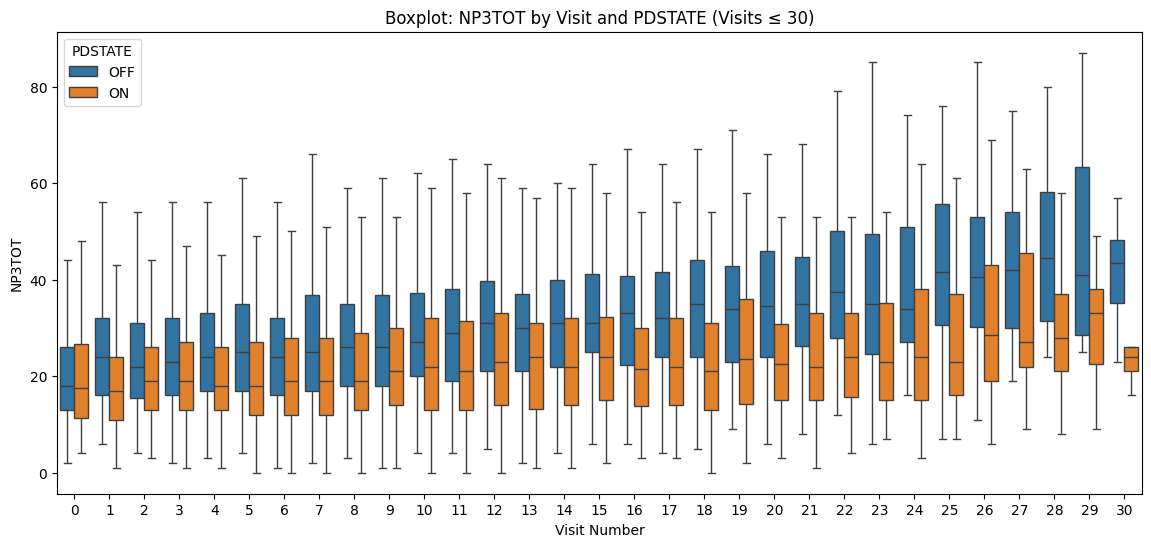

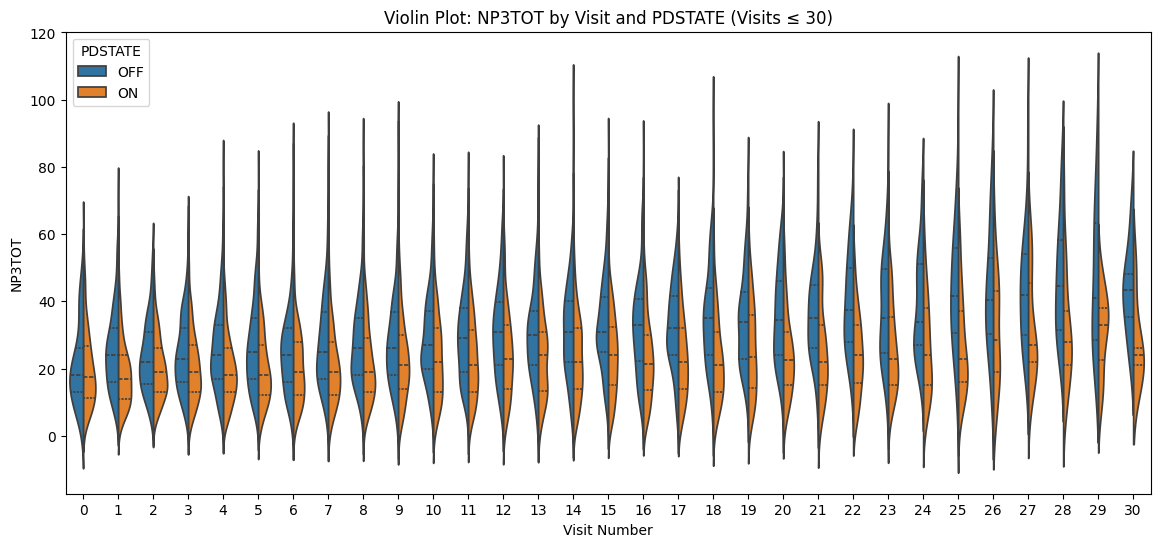

In [46]:
plt.figure(figsize=(10, 5))
data['PDSTATE'] = data['PDSTATE'].astype('category')
# Limit to VISIT_NUM <= 30
plot_data = data[data['VISIT_NUM'] <= 30]
for state in plot_data['PDSTATE'].cat.categories:
    state_data = plot_data[plot_data['PDSTATE'] == state]
    mean_trend = state_data.groupby('VISIT_NUM')['NP3TOT'].mean()
    plt.plot(mean_trend.index, mean_trend.values, marker='o', label=f'{state} Mean')
plt.xlabel('Visit Number')
plt.ylabel('Mean NP3TOT')
plt.title('Mean NP3TOT by Visit Number and PDSTATE (Visits ≤ 30)')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=plot_data, showfliers=False)
plt.title('Boxplot: NP3TOT by Visit and PDSTATE (Visits ≤ 30)')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=plot_data, split=True, inner='quartile')
plt.title('Violin Plot: NP3TOT by Visit and PDSTATE (Visits ≤ 30)')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()